### Requisites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier



In [54]:
df = pd.read_csv('credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [55]:
df.shape

(32581, 12)

# Data Cleaning

### Removing Duplicates

In [56]:
df.drop_duplicates(inplace=True)
df.shape

(32416, 12)

### Missing Values

In [57]:
# Identify the missing values in the dataset
missing_summary = df.isnull().sum()
print(missing_summary)


person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [58]:
#Replace missing Employment Length data with the median
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)

#Remove rows with missing loan interest rate
df.drop(df[df['loan_int_rate'].isna()].index, inplace=True)


C:\Users\akshi\AppData\Local\Temp\ipykernel_36080\2738293196.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)


In [59]:
# Identify the missing values in the dataset
missing_summary = df.isnull().sum()
print(missing_summary)

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


### Check and correct data types

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29321 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  29321 non-null  int64  
 1   person_income               29321 non-null  int64  
 2   person_home_ownership       29321 non-null  object 
 3   person_emp_length           29321 non-null  float64
 4   loan_intent                 29321 non-null  object 
 5   loan_grade                  29321 non-null  object 
 6   loan_amnt                   29321 non-null  int64  
 7   loan_int_rate               29321 non-null  float64
 8   loan_status                 29321 non-null  int64  
 9   loan_percent_income         29321 non-null  float64
 10  cb_person_default_on_file   29321 non-null  object 
 11  cb_person_cred_hist_length  29321 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.9+ MB


In [62]:
# Change type to 'category'
df['person_home_ownership'] = df['person_home_ownership'].astype('category')
df['loan_intent'] = df['loan_intent'].astype('category')
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 29321 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   person_age                  29321 non-null  int64   
 1   person_income               29321 non-null  int64   
 2   person_home_ownership       29321 non-null  category
 3   person_emp_length           29321 non-null  float64 
 4   loan_intent                 29321 non-null  category
 5   loan_grade                  29321 non-null  object  
 6   loan_amnt                   29321 non-null  int64   
 7   loan_int_rate               29321 non-null  float64 
 8   loan_status                 29321 non-null  int64   
 9   loan_percent_income         29321 non-null  float64 
 10  cb_person_default_on_file   29321 non-null  object  
 11  cb_person_cred_hist_length  29321 non-null  int64   
dtypes: category(2), float64(3), int64(5), object(2)
memory usage: 2.5+ MB


### Outlier detection

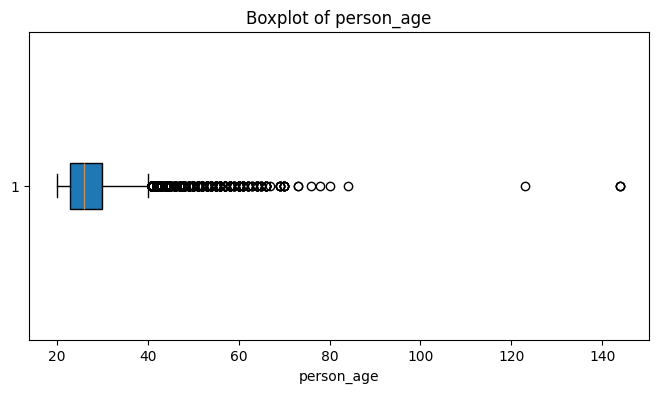

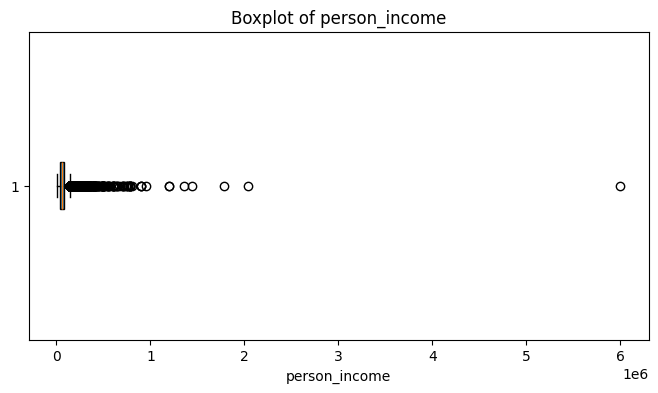

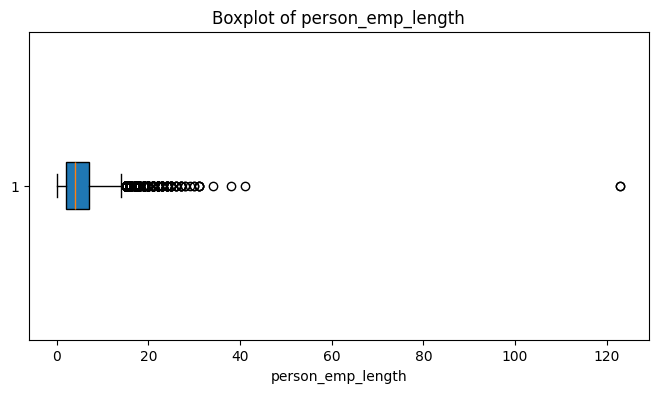

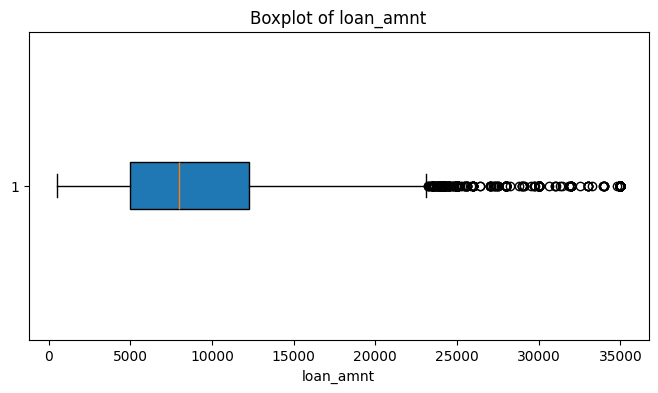

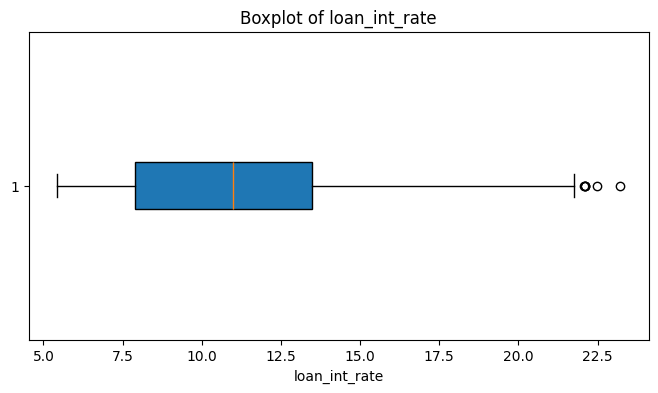

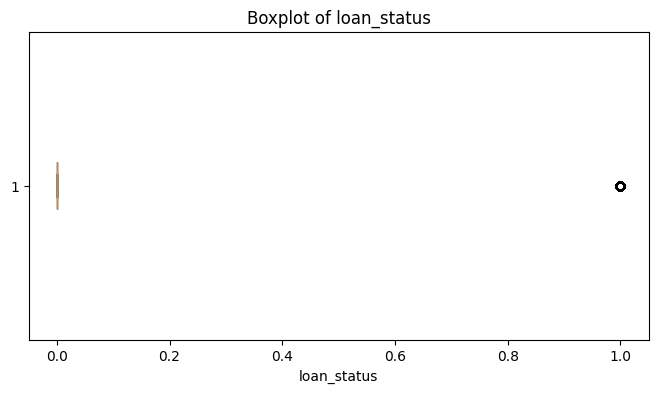

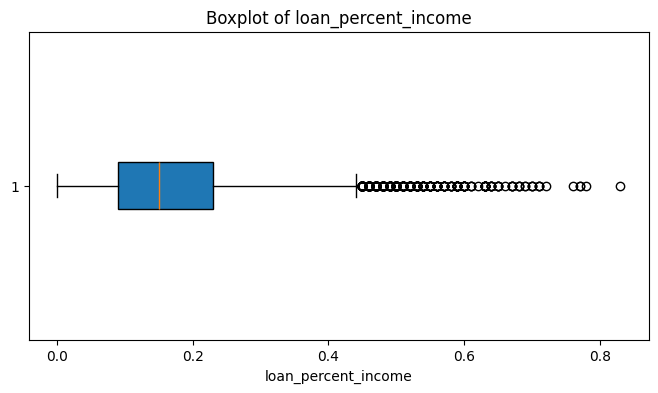

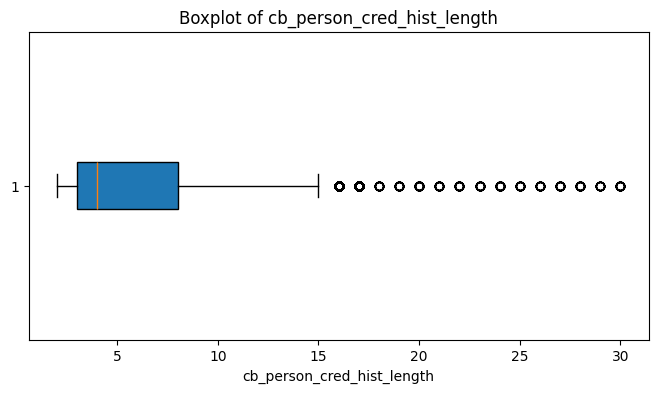

In [63]:
#Plot boxplots for every column to visualize outliers, if any
for column in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 4))  # Create a new figure for each plot
    plt.boxplot(df[column].dropna(), vert=False, patch_artist=True)
    plt.title(f"Boxplot of {column}")
    plt.xlabel(column)
    plt.show()

In [64]:
# Drop all records with person's age greater than 80
df.drop(df[df['person_age']>80].index, inplace= True)
df.shape

(29316, 12)

In [65]:
# Replace records where employment length greater than 40 with the mean employment length of the dataset
df.loc[df['person_emp_length'] > 40, 'person_emp_length'] = df['person_emp_length'].mean()

38.0


In [ ]:
# Remove people with personal income less or more than 1.5*IQR
Q1 = df['person_income'].quantile(0.25)
Q3 = df['person_income'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['person_income'] < (Q1 - 1.5 * IQR)) | (df['person_income'] > (Q3 + 1.5 * IQR))].index
df.drop(outliers, inplace=True)


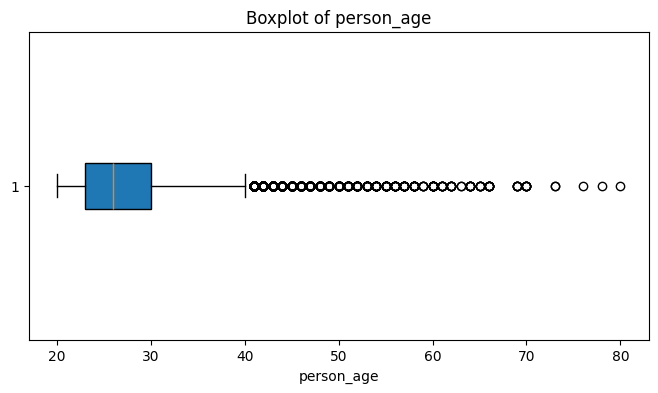

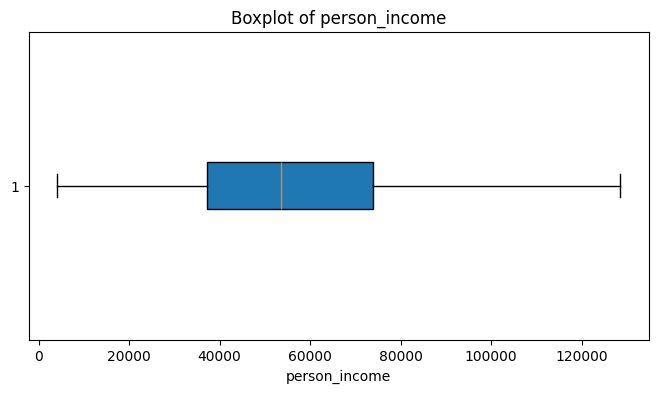

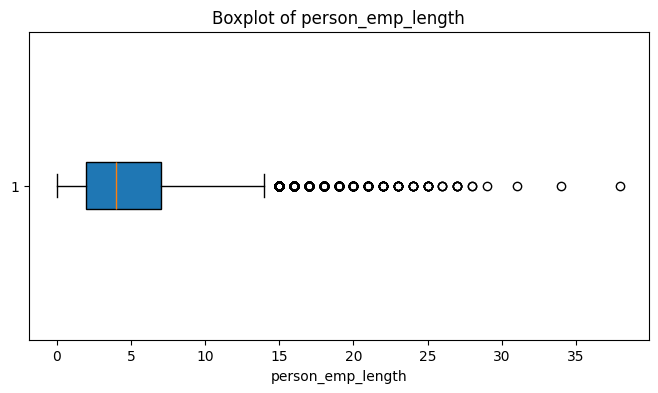

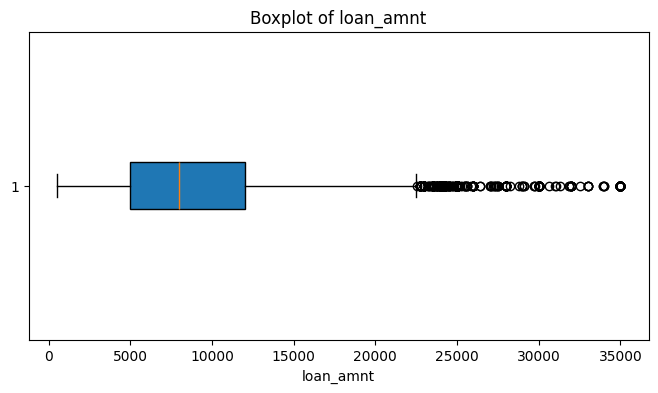

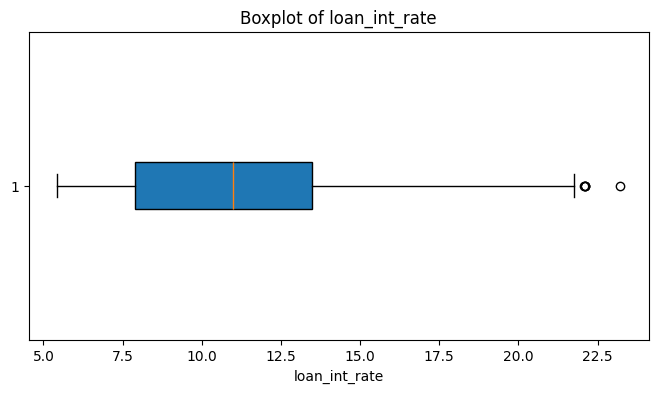

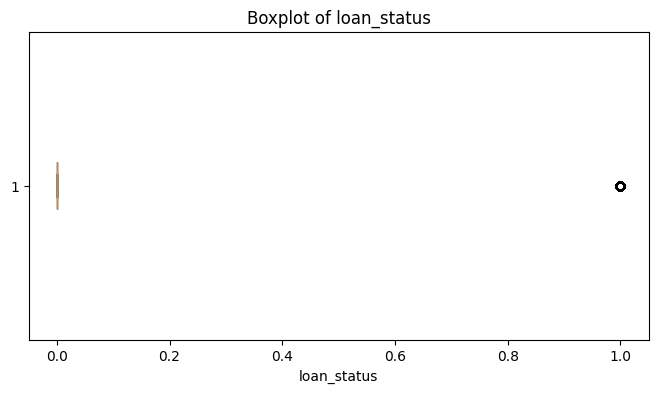

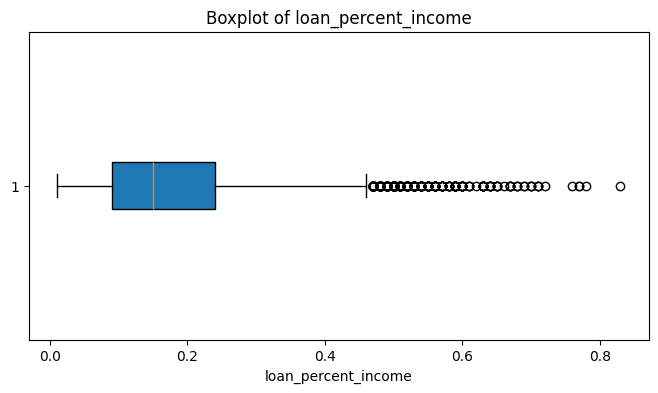

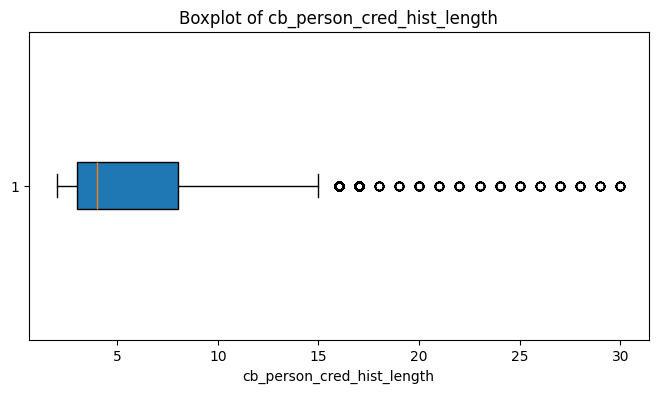

In [82]:
#Replot after handling outliers
for column in df.select_dtypes(include='number').columns:
    plt.figure(figsize=(8, 4))  # Create a new figure for each plot
    plt.boxplot(df[column].dropna(), vert=False, patch_artist=True)
    plt.title(f"Boxplot of {column}")
    plt.xlabel(column)
    plt.show()

# Exploratory Data Analysis

### Descriptive Statistics


In [69]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,29316.000000,2.931600e+04,29316.000000,29316.000000,29316.000000,29316.000000,29316.000000,29316.000000
mean,27.709476,6.581504e+04,4.758743,9587.694433,11.017237,0.219948,0.170156,5.794174
std,6.162163,5.130408e+04,3.977439,6316.388668,3.241836,0.414218,0.106897,4.033046
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.905000e+04,7.000000,12250.000000,13.472500,0.000000,0.230000,8.000000
max,80.000000,2.039784e+06,38.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


### Target Variable Statistics

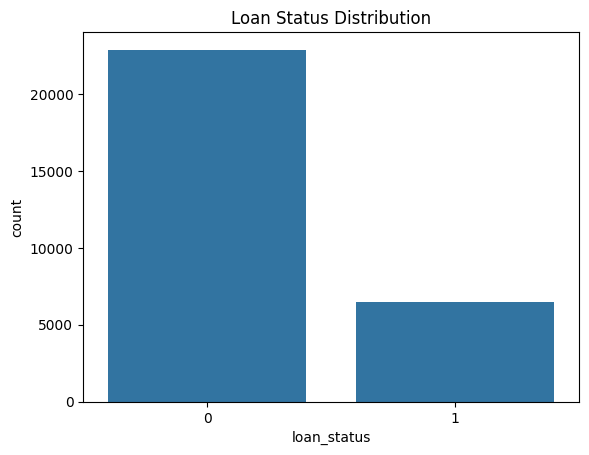

loan_status
0    78.005185
1    21.994815
Name: count, dtype: float64

In [72]:
sns.countplot(data=df, x='loan_status')
plt.title('Loan Status Distribution')
plt.show()

df['loan_status'].value_counts()*100/df.shape[0]

### Univariate Analysis

(array([4.290e+03, 6.413e+03, 6.467e+03, 2.943e+03, 2.792e+03, 1.285e+03,
        1.337e+03, 5.580e+02, 5.580e+02, 2.450e+02, 2.320e+02, 1.010e+02,
        1.010e+02, 4.200e+01, 4.400e+01, 1.800e+01, 2.400e+01, 9.000e+00,
        1.200e+01, 5.000e+00, 6.000e+00, 2.000e+00, 1.000e+00, 2.000e+00]),
 array([20. , 22.5, 25. , 27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. ,
        47.5, 50. , 52.5, 55. , 57.5, 60. , 62.5, 65. , 67.5, 70. , 72.5,
        75. , 77.5, 80. ]),
 <BarContainer object of 24 artists>)

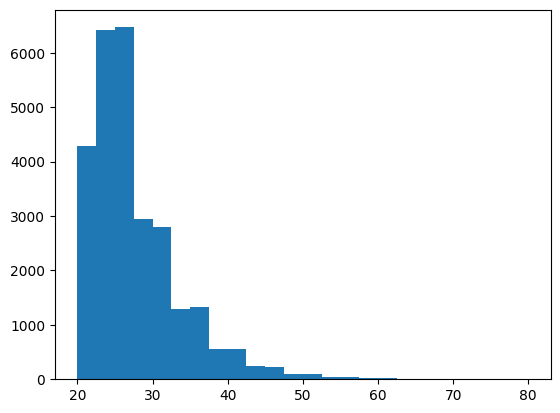

In [109]:
plt.hist(df['person_age'], bins= 24)

### Bivariate Analysis 

#### Questions to ask:
1. Does person_income impact loan_status?
2. Is there a relationship between loan_grade and loan_int_rate?
3. What are the features that affect the dependent (loan status) the most?

#### Effect of Income, Loan Amount on Loan Status

<Axes: xlabel='person_income', ylabel='loan_amnt'>

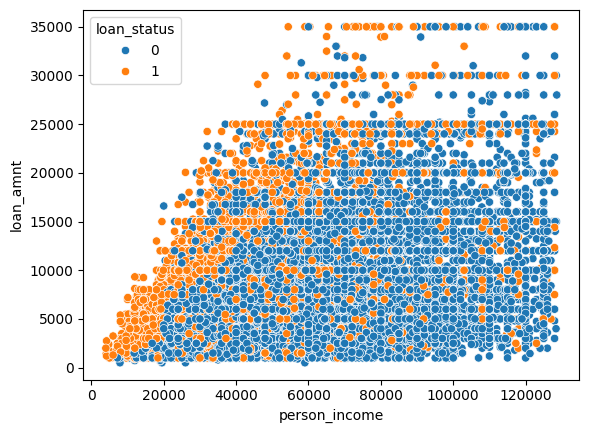

In [83]:
sns.scatterplot(x='person_income', y='loan_amnt', hue='loan_status', data=df)
#Result: People with lesser income are more likely to default on the loan

#### Effect of Age, Loan Amount on Loan Status

<Axes: xlabel='person_age', ylabel='loan_amnt'>

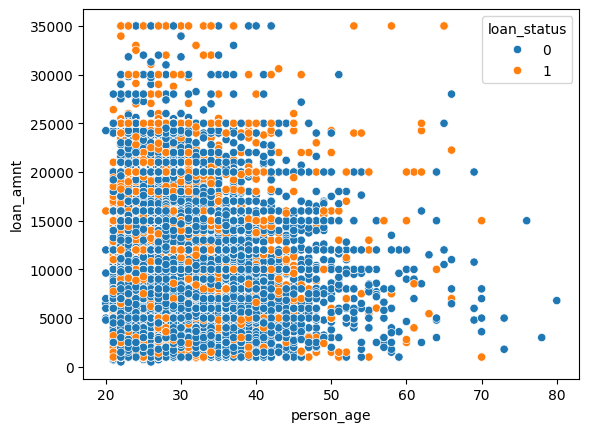

In [104]:
sns.scatterplot(x='person_age', y='loan_amnt', hue='loan_status', data=df)

#### Mean Loan Amount taken for different Loan Intents

In [125]:
# Group Statistics
# group_stats = df.groupby('loan_intent')['loan_amnt'].mean()
# print(group_stats)

pd.crosstab(df['loan_intent'], df['loan_status'], values= df['loan_amnt'], aggfunc='mean')



loan_status,0,1
loan_intent,,
DEBTCONSOLIDATION,8522.485446,10862.412587
EDUCATION,8798.743635,10771.661570
HOMEIMPROVEMENT,9910.511101,9550.000000
MEDICAL,8131.482971,10994.456067
PERSONAL,8895.345997,10374.796954
VENTURE,8813.777916,11065.294511


#### Effect of Loan Intent on Loan Status

loan_status           0     1
loan_intent                  
DEBTCONSOLIDATION  3092  1287
EDUCATION          4517   981
HOMEIMPROVEMENT    2162   838
MEDICAL            3729  1434
PERSONAL           3685   985
VENTURE            4030   747


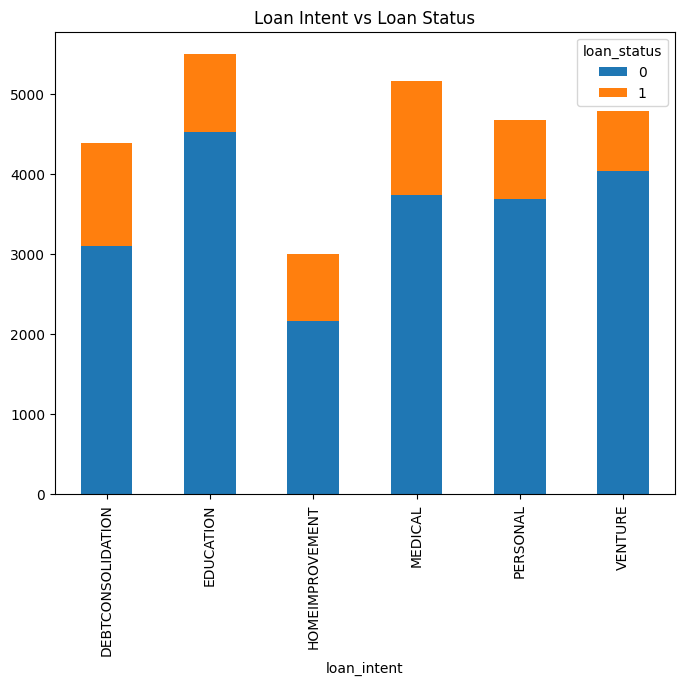

In [93]:
pd1 = pd.crosstab(df['loan_intent'], df['loan_status'])
print(pd1)

pd1.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Loan Intent vs Loan Status')
plt.show()


#### How does loan interest rates vary across the defaulters and non-defaulters

loan_status
0    10.405930
1    13.007049
Name: loan_int_rate, dtype: float64


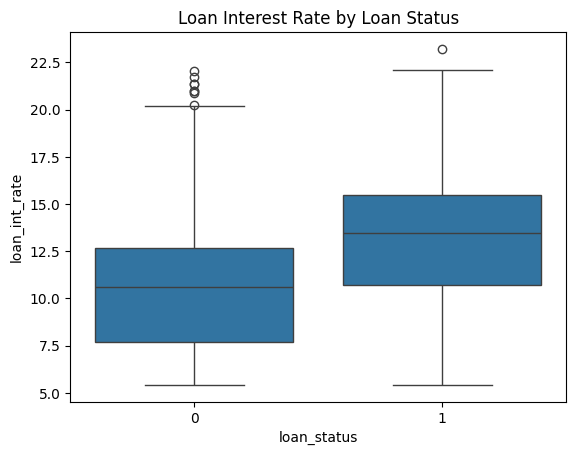

In [114]:
int_rates_mean = df.groupby('loan_status')['loan_int_rate'].mean()
print(int_rates_mean)

sns.boxplot(x=df['loan_status'], y=df['loan_int_rate'])
plt.title('Loan Interest Rate by Loan Status')
plt.show()

#### How does loan interest rates vary among the defaulters and non-defaulters across different types of loans (loan intent)

In [98]:
pd2= pd.crosstab(df['loan_intent'], df['loan_status'], values=df['loan_int_rate'], aggfunc='mean')
print(pd2)

loan_status                0          1
loan_intent                            
DEBTCONSOLIDATION   9.998393  13.318578
EDUCATION          10.600545  12.419021
HOMEIMPROVEMENT    10.531536  12.844368
MEDICAL            10.192320  13.356799
PERSONAL           10.564000  12.597259
VENTURE            10.486213  13.293989


### Statistical Analysis

##### T-Test: Interest Rate on Loan Status 

In [101]:
# T-Test

default_loans = df[df['loan_status'] == 1]['loan_int_rate']
non_default_loans = df[df['loan_status'] == 0]['loan_int_rate']
t_stat, p_val = ttest_ind(default_loans, non_default_loans)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

#Results
# Highly positive t-statistic suggests a large difference between the interest rates of the 2 groups 
# (mean of int rate of defaulters > mean of int rate of non-defaulters)
# p_value < 0.05 indicates that the relationship is statistically significant

T-statistic: 59.44297782114812, P-value: 0.0


##### T-Test: Person Income on Loan Status

In [103]:
# T-Test

default_loans = df[df['loan_status'] == 1]['person_income']
non_default_loans = df[df['loan_status'] == 0]['person_income']
t_stat, p_val = ttest_ind(default_loans, non_default_loans)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

# Results
# Highly negative t-statistic suggests a large difference between the income of the 2 groups 
# (mean income of defaulters << mean income of non-defaulters)
# p_value < 0.05 indicates that the relationship is statistically significant

T-statistic: -43.898400723913184, P-value: 0.0


##### Chi-Square Test: Loan Intent on Loan Status

In [120]:
contingency_table = pd.crosstab(df['loan_intent'], df['loan_status'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Test p-value: {p}")

# Result
# p-value less than 0.05 suggest a highly significant relation between the 2 variables (H0 rejected)

Chi-Square Test p-value: 7.978241379134397e-95


In [126]:
# Total number of defaulters and non-defaulters across the different loan intent categories
print(contingency_table)

loan_status           0     1
loan_intent                  
DEBTCONSOLIDATION  3092  1287
EDUCATION          4517   981
HOMEIMPROVEMENT    2162   838
MEDICAL            3729  1434
PERSONAL           3685   985
VENTURE            4030   747


# Predictive Modelling

#### Encode categorical data

In [129]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [131]:
df.shape

(27487, 25)

In [133]:
# X and y will be thought of as the entire training data
# X_test and y_test will be thought of as the out of sample data for model evaluation

X_train, X_test, y_train, y_test = train_test_split(df.drop('loan_status', axis=1), df['loan_status'],
                                        random_state=0,  test_size=0.2, stratify=df['loan_status'],
                                        shuffle=True)

#### Logistic Regression

In [134]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [135]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [136]:
y_pred = log_reg.predict(X_test)

In [138]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8584939978173881


In [139]:
# Classification Report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4243
           1       0.77      0.54      0.64      1255

    accuracy                           0.86      5498
   macro avg       0.82      0.75      0.77      5498
weighted avg       0.85      0.86      0.85      5498

Confusion Matrix:
[[4038  205]
 [ 573  682]]


#### Random Forest (Best Accuracy)

In [140]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

In [141]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [142]:
y_pred = rf.predict(X_test)

In [143]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9281556929792651


In [144]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4243
           1       0.96      0.71      0.82      1255

    accuracy                           0.93      5498
   macro avg       0.94      0.85      0.89      5498
weighted avg       0.93      0.93      0.92      5498

Confusion Matrix:
[[4209   34]
 [ 361  894]]


#### Decision Tree

In [169]:
# Define the list of categorical columns
# Define categorical columns based on the one-hot encoding you mentioned
categorical_columns = [
    'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT',
    'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
    'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
    'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_Y', 'loan_risk_Medium', 
    'loan_risk_High'
]

# Define the preprocessor for numerical columns (impute missing values) and use the one-hot encoded columns directly
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']),
        ('cat', 'passthrough', categorical_columns)  # 'passthrough' allows the one-hot encoded columns to pass through unchanged
    ]
)


# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Train the model
model.fit(X_train, y_train)

# Predict the test set
y_pred = model.predict(X_test)



In [170]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      4238
           1       0.75      0.76      0.75      1260

    accuracy                           0.89      5498
   macro avg       0.84      0.84      0.84      5498
weighted avg       0.89      0.89      0.89      5498

Confusion Matrix:
[[3912  326]
 [ 305  955]]
